## Anshul Agrawal 12211984

## Analysis on Small trades files

### Importing Modules

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot as plt

### Reading the small trades data files

In [2]:
dfT = pd.read_csv("mkt_make_BTC_hw_small__trades.tab", sep='\t')
dflev = pd.read_csv("mkt_make_BTC_hw_small__book_lev_2.tab", sep='\t')

### Modifying the columns to the correct scale and dropping the irrelevant columns

In [3]:
dflev['Ask1PriceMillionths'] = dflev['Ask1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
dflev['Ask1SizeBillionths'] = dflev['Ask1SizeBillionths'].apply(lambda x: np.float(x)/np.float(10**9))
dflev['Bid1PriceMillionths'] = dflev['Bid1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
dflev['Bid1SizeBillionths'] = dflev['Bid1SizeBillionths'].apply(lambda x: np.float(x)/np.float(10**9))
dflev.drop(columns = ['Ask2PriceMillionths','Ask3PriceMillionths','Ask2SizeBillionths','Ask3SizeBillionths',\
                      'Bid2PriceMillionths','Bid2SizeBillionths','Bid3PriceMillionths','Bid3SizeBillionths'] ,inplace = True)

### Merging the tables on a Price-Timestamp pair
    - Two separate tables for bid and ask

In [4]:
dfT["PriceTimePairAsk"] = (dfT["timestamp_utc_microseconds"].map(int)).map(str) + dfT["Price"].map(str)
dflev["PriceTimePairAsk"] = (dflev["timestamp_utc_microseconds"].map(int)).map(str) + dflev["Ask1PriceMillionths"].map(str)
dfAsk = pd.merge(dfT,dflev, on = 'PriceTimePairAsk', how = 'inner')
dfAsk.drop(columns = ['timestamp_utc_microseconds_y','PriceTimePairAsk'], inplace = True)
dfAsk.rename(columns = {'timestamp_utc_microseconds_x':'timestamp_utc_microseconds'}, inplace = True)
dfT.drop(columns = ['PriceTimePairAsk'], inplace = True)

In [5]:
dfAsk.head()

,timestamp_utc_microseconds,Price,Size,Ask1PriceMillionths,Ask1SizeBillionths,Bid1PriceMillionths,Bid1SizeBillionths,received_utc_microseconds
0,1523225288293000,7035.55,0.1034,7035.55,65.958939,7035.54,5.584317,1523225288307619
1,1523225299105000,7035.55,0.1502,7035.55,65.876289,7035.54,5.201242,1523225299120169
2,1523225334890000,7035.55,0.0469,7035.55,64.883748,7035.54,3.471626,1523225334906053
3,1523225334890000,7035.55,0.0469,7035.55,64.881119,7035.54,3.471626,1523225334910150
4,1523225334890000,7035.55,0.0469,7035.55,64.879911,7035.54,3.471626,1523225334946847


In [6]:
dfT["PriceTimePairBid"] = dfT["timestamp_utc_microseconds"].map(str) + dfT["Price"].map(str)
dflev["PriceTimePairBid"] = dflev["timestamp_utc_microseconds"].map(str) + dflev["Bid1PriceMillionths"].map(str)
dfBid = pd.merge(dfT,dflev, on = 'PriceTimePairBid', how = 'inner')
dfBid.drop(columns = ['timestamp_utc_microseconds_y','PriceTimePairBid','PriceTimePairAsk'], inplace = True)
dfBid.rename(columns = {'timestamp_utc_microseconds_x':'timestamp_utc_microseconds'}, inplace = True)
dfT.drop(columns = ['PriceTimePairBid'], inplace = True)

In [7]:
dfBid.head()

,timestamp_utc_microseconds,Price,Size,Ask1PriceMillionths,Ask1SizeBillionths,Bid1PriceMillionths,Bid1SizeBillionths,received_utc_microseconds
0,1523225293472000,7035.54,0.3900,7035.55,66.015939,7035.54,5.201242,1523225293492054
1,1523225300858000,7035.54,0.0630,7035.55,63.821910,7035.54,5.193785,1523225300873077
2,1523225300858000,7035.54,0.0630,7035.55,63.821910,7035.54,5.138242,1523225300875415
3,1523225303087000,7035.54,0.1030,7035.55,63.721780,7035.54,5.035242,1523225303216114
4,1523225310531000,7035.54,0.0322,7035.55,63.721780,7035.54,5.034372,1523225310546098


### Concatenating the bid-ask tables to form one single table and then sorting the rows in ascending order of received timestamp

In [8]:
df = pd.concat([dfAsk,dfBid], axis = 0).reset_index(drop = True)
df.sort_values(by = ['received_utc_microseconds'], inplace = True)
df.drop(columns = ['Ask1SizeBillionths','Bid1SizeBillionths','received_utc_microseconds'], inplace = True)
df.drop_duplicates(inplace = True)
df.head()

,timestamp_utc_microseconds,Price,Size,Ask1PriceMillionths,Bid1PriceMillionths
0,1523225288293000,7035.55,0.1034,7035.55,7035.54
17,1523225293472000,7035.54,0.3900,7035.55,7035.54
1,1523225299105000,7035.55,0.1502,7035.55,7035.54
18,1523225300858000,7035.54,0.0630,7035.55,7035.54
20,1523225303087000,7035.54,0.1030,7035.55,7035.54


In [9]:
def PnLMarketMaker(df,s,j,k):
    df['Trade'] = 0.0 * len(df.index)
    df['Cash'] = 0.0 * len(df.index)
    df['CashI/O'] = 0.0 * len(df.index)
    df['Position'] = 0.0 * len(df.index)
    df['timestamp_utc_microseconds'] = df['timestamp_utc_microseconds'].apply(lambda x: \
                                                                                    datetime.datetime.fromtimestamp(x/(10**6)))
    
    df.loc[df['Price'] == df['Ask1PriceMillionths'],'Trade'] = -s
    df.loc[df['Price'] == df['Bid1PriceMillionths'],'Trade'] = s

    #Participation criteria:
    
    for i in range(0,len(df.index)):
        if ((abs(df.iat[i,2]) <= 4 * s) or (df.iat[i-1,8] + s > j)) and df.iat[i,5] == s:
            df.iat[i,5] = 0
        elif ((abs(df.iat[i,2]) <= 4 * s) or (df.iat[i-1,8] -s < -k))  and df.iat[i,5] == -s:
            df.iat[i,5] = 0
            
        df.iat[i,8] = df.iat[i-1,8] + df.iat[i,5]
    
    df['CashI/O'] = - df['Trade'] * df['Price']
    df['Cash'] = df['CashI/O'].cumsum()
    
    df.drop(df[df['Trade'] == 0].index, inplace = True)
    
    df = df.reset_index(drop = True)
    
    return df

In [10]:
a = PnLMarketMaker(df,0.01,0.055,0.035)
a

,timestamp_utc_microseconds,Price,Size,Ask1PriceMillionths,Bid1PriceMillionths,Trade,Cash,CashI/O,Position
0,2018-04-08 17:08:08.293,7035.55,0.103400,7035.55,7035.54,-0.01,70.3555,70.3555,-0.01
1,2018-04-08 17:08:13.472,7035.54,0.390000,7035.55,7035.54,0.01,0.0001,-70.3554,0.00
2,2018-04-08 17:08:19.105,7035.55,0.150200,7035.55,7035.54,-0.01,70.3556,70.3555,-0.01
3,2018-04-08 17:08:20.858,7035.54,0.063000,7035.55,7035.54,0.01,0.0002,-70.3554,0.00
4,2018-04-08 17:08:23.087,7035.54,0.103000,7035.55,7035.54,0.01,-70.3552,-70.3554,0.01
5,2018-04-08 17:08:42.770,7035.54,0.122300,7035.55,7035.54,0.01,-140.7106,-70.3554,0.02
6,2018-04-08 17:08:47.415,7035.54,0.495897,7035.55,7035.54,0.01,-211.0660,-70.3554,0.03
7,2018-04-08 17:08:49.413,7035.54,0.103000,7035.55,7035.54,0.01,-281.4214,-70.3554,0.04
8,2018-04-08 17:08:51.663,7035.54,0.840149,7035.55,7035.54,0.01,-351.7768,-70.3554,0.05
9,2018-04-08 17:08:54.890,7035.55,0.046900,7035.55,7035.54,-0.01,-281.4213,70.3555,0.04


#### Conclusion
    1) Sample Output matches with the one given in the HW assignment file.

### Plot for the trading points of the market maker

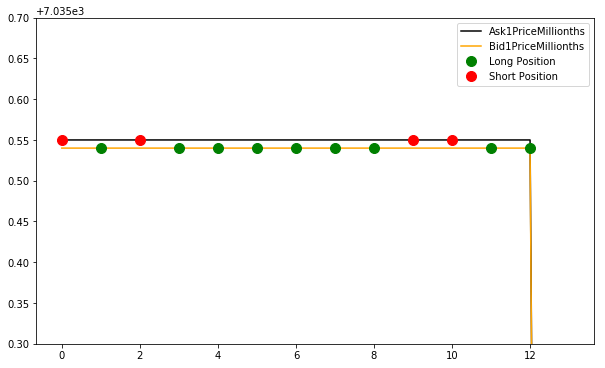

In [11]:
long = a.loc[a['Trade'] == 0.01]
short = a.loc[a['Trade'] == -0.01]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
plt.plot(a.index, a['Ask1PriceMillionths'], 'b-', color="black")
plt.plot(a.index, a['Bid1PriceMillionths'], 'b-',color="orange")
plt.plot(long.index, long['Bid1PriceMillionths'],'ro', color="green", markersize=10, label = 'Long Position')
plt.plot(short.index, short['Ask1PriceMillionths'],'ro', color="red", markersize=10, label = 'Short Position')
plt.ylim(top = 7035.7, bottom = 7035.3)

ax.legend()

plt.show()

## Conclusion

## Analysis on Big Trade Files 2018

In [4]:
DFTrade = pd.read_csv('mkt_make_BTC_hw_big__trades.tab', sep = '\t')
DFBook = pd.read_csv('mkt_make_BTC_hw_big__book_lev_2.tab', sep = '\t')
    
DFBook.drop(columns = ['Ask2PriceMillionths','Ask3PriceMillionths','Ask2SizeBillionths','Ask3SizeBillionths',\
                          'Bid2PriceMillionths','Bid2SizeBillionths','Bid3PriceMillionths','Bid3SizeBillionths'] \
               ,inplace = True)
DFBook['Ask1PriceMillionths'] = DFBook['Ask1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
DFBook['Bid1PriceMillionths'] = DFBook['Bid1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))

### Plot of Bitcoin Bid-Ask Price Data

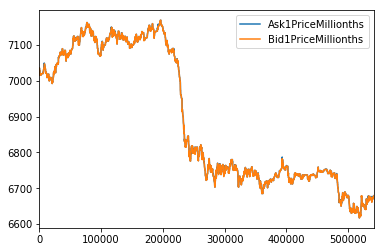

In [5]:
DFBook[['Ask1PriceMillionths','Bid1PriceMillionths']].plot()
plt.show()

### Conclusion
    1) We can observe from the above plot that the bitcoin price took a hit in the 2018 data provided.

In [14]:
def PnLMarketMaker(s,j,k,flag):
    
    DFTrade = pd.read_csv('mkt_make_BTC_hw_big__trades.tab', sep = '\t')
    DFBook = pd.read_csv('mkt_make_BTC_hw_big__book_lev_2.tab', sep = '\t')
    
    DFBook.drop(columns = ['Ask2PriceMillionths','Ask3PriceMillionths','Ask2SizeBillionths','Ask3SizeBillionths',\
                          'Bid2PriceMillionths','Bid2SizeBillionths','Bid3PriceMillionths','Bid3SizeBillionths'] \
               ,inplace = True)
    
    DFBook['Ask1PriceMillionths'] = DFBook['Ask1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
    DFBook['Ask1SizeBillionths'] = DFBook['Ask1SizeBillionths'].apply(lambda x: np.float(x)/np.float(10**9))
    DFBook['Bid1PriceMillionths'] = DFBook['Bid1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
    DFBook['Bid1SizeBillionths'] = DFBook['Bid1SizeBillionths'].apply(lambda x: np.float(x)/np.float(10**9))
    
    DFTrade["PriceTimePairAsk"] = (DFTrade["timestamp_utc_microseconds"].map(int)).map(str) + DFTrade["Price"].map(str)
    DFBook["PriceTimePairAsk"] = (DFBook["timestamp_utc_microseconds"].map(int)).map(str) + \
                                                DFBook["Ask1PriceMillionths"].map(str)
    dfAsk = pd.merge(DFTrade,DFBook, on = 'PriceTimePairAsk', how = 'inner')
    dfAsk.drop(columns = ['timestamp_utc_microseconds_y','PriceTimePairAsk'], inplace = True)
    dfAsk.rename(columns = {'timestamp_utc_microseconds_x':'timestamp_utc_microseconds'}, inplace = True)
    DFTrade.drop(columns = ['PriceTimePairAsk'], inplace = True)
    
    DFTrade["PriceTimePairBid"] = (DFTrade["timestamp_utc_microseconds"].map(int)).map(str) + DFTrade["Price"].map(str)
    DFBook["PriceTimePairBid"] = (DFBook["timestamp_utc_microseconds"].map(int)).map(str) + \
                                                DFBook["Bid1PriceMillionths"].map(str)
    
    dfBid = pd.merge(DFTrade,DFBook, on = 'PriceTimePairBid', how = 'inner')
    dfBid.drop(columns = ['timestamp_utc_microseconds_y','PriceTimePairBid','PriceTimePairAsk'], inplace = True)
    dfBid.rename(columns = {'timestamp_utc_microseconds_x':'timestamp_utc_microseconds'}, inplace = True)
    DFTrade.drop(columns = ['PriceTimePairBid'], inplace = True)
    
    df = pd.concat([dfAsk,dfBid], axis = 0).reset_index(drop = True)
    df.sort_values(by = ['received_utc_microseconds'], inplace = True)
    df.drop(columns = ['Ask1SizeBillionths','Bid1SizeBillionths','received_utc_microseconds'], inplace = True)
    df.drop_duplicates(inplace = True)
    
    df['Trade'] = 0.0 * len(df.index)
    df['Cash'] = 0.0 * len(df.index)
    df['CashI/O'] = 0.0 * len(df.index)
    df['Position'] = 0.0 * len(df.index)
    
    df['timestamp_utc_microseconds'] = df['timestamp_utc_microseconds'].apply(lambda x: \
                                                                                    datetime.datetime.fromtimestamp(x/(10**6)))
    df.loc[df['Price'] == df['Ask1PriceMillionths'],'Trade'] = -s
    df.loc[df['Price'] == df['Bid1PriceMillionths'],'Trade'] = s
        
    #Participation criteria:
    
    for i in range(0,len(df.index)):
        if (abs(df.iat[i,2]) <= 4 * s) or ((df.iat[i-1,8] + s > j) and df.iat[i,5] == s):
            df.iat[i,5] = 0
        elif (abs(df.iat[i,2]) <= 4 * s or ((df.iat[i-1,8] -s < -k))  and df.iat[i,5] == -s):
            df.iat[i,5] = 0
            
        df.iat[i,8] = df.iat[i-1,8] + df.iat[i,5]
    
    df['CashI/O'] = - df['Trade'] * df['Price']
    df['Cash'] = df['CashI/O'].cumsum()
    
    last = df['Price'].count()
    
   #Unwinding the trade position at the last trading point at the mid-price.
    
    if df.iat[last-1,8] != 0:
        df.iat[last-1,5] = - df.iat[last-1,8]
        df.iat[last-1,8] = 0
        
        #Exit the position at the last data point at the mid-price
        
        df.iat[last-1,7] = - df.iat[last-1,5] * (df.iat[last-1, 3] + df.iat[last-1,4])/2
        df.iat[last-1,6] = df.iat[last-2,6] + df.iat[last-1,7]
       
    df.set_index(['timestamp_utc_microseconds'], inplace = True)
    trade_count = len(df[df['Trade'] != 0].index)
    trade_bid = len(df[df['Trade'] == s].index)             # To check the count of trades happening at the bid
    trade_ask = len(df[df['Trade'] == -s].index)            # To check the count of trades happening at the ask
    
    if flag == 1:
        return (df.iat[last-1,5],trade_count,trade_bid,trade_ask)
    else:
        return df

### Trying different parameter values to obtain trends

In [15]:
results,val = [],[]
for s in [0.01,0.02,0.03,0.05,0.07]:
    for j in [0.03,0.04,0.05,0.07,0.1]:
        for k in [0.01,0.02,0.03,0.05,0.07,0.1]:
            a = PnLMarketMaker(s,j,k,1)
            results.append(a[0])
            val.append([s,j,k,a[1],a[2],a[3]])

In [16]:
a = pd.DataFrame(val)
b = pd.DataFrame(results)
a = a.rename(columns={0: "s", 1: "j", 2: "k", 3: "Trade Count", 4: "Bid Trades", 5: "Ask Trades"})
b = b.rename(columns = {0: "PnL"})
c = pd.concat([a,b],axis = 1)
c = c.drop(c[c.s >= c.j].index)
c = c.drop(c[c.s >= c.k].index)
c = c.drop(c[c.k >= c.j].index)
c = c.sort_values(by=['PnL'], ascending = True)
c.head(10)

,s,j,k,Trade Count,Bid Trades,Ask Trades,PnL
118,0.05,0.10,0.07,3732,1866,1866,-253.92225
88,0.03,0.10,0.07,5437,2717,2719,-237.78780
58,0.02,0.10,0.07,7264,3630,3633,-228.27870
57,0.02,0.10,0.05,7015,3506,3508,-215.14460
87,0.03,0.10,0.05,5122,2561,2561,-206.74365
56,0.02,0.10,0.03,6746,3372,3373,-199.42610
28,0.01,0.10,0.07,10282,5137,5144,-172.74985
51,0.02,0.07,0.05,6441,3219,3221,-166.15360
27,0.01,0.10,0.05,9907,4951,4955,-165.35360
81,0.03,0.07,0.05,4726,2363,2363,-159.48045


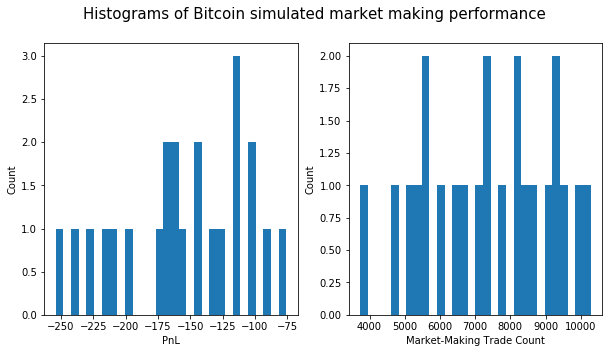

In [17]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize=(10, 5))
fig.suptitle('Histograms of Bitcoin simulated market making performance',fontsize = 15)

plt.subplot(1,2,1)
plt.hist(c['PnL'], bins = 30)
plt.xlabel("PnL")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(c['Trade Count'], bins = 30)
plt.xlabel("Market-Making Trade Count")
plt.ylabel("Count")

plt.show()

### Conclusion
    1) From the above histogram for PnL we can observe that market making in Bitcoin is not a profitable business. In all the simulations we lose money. The reason being the spreads are very low and there is a high risk of being run over causing losses.
    2) The set of parameters used to generate above simulations generate enough trading oportunities as seen from the above Market making trade count - a measure of participation by the market maker.

### Scatter Plots of the results obtained for various set of parameters

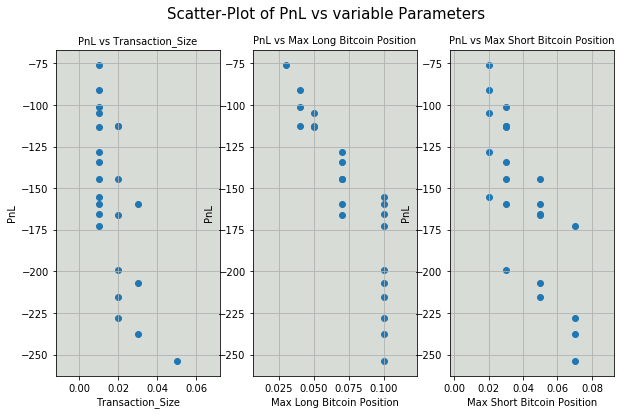

In [18]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize=(10, 6))
fig.suptitle('Scatter-Plot of PnL vs variable Parameters',fontsize = 15)

plt.subplot(1,3,1)
plt.scatter(c['s'],c['PnL'])
plt.title("PnL vs Transaction_Size",fontsize = 10)
plt.xlabel("Transaction_Size")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.subplot(1,3,2)
plt.scatter(c['j'],c['PnL'])
plt.title("PnL vs Max Long Bitcoin Position",fontsize = 10)
plt.xlabel("Max Long Bitcoin Position")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')


plt.subplot(1,3,3)
plt.scatter(c['k'],c['PnL'])
plt.title("PnL vs Max Short Bitcoin Position",fontsize = 10)
plt.xlabel("Max Short Bitcoin Position")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.show()

### Conclusion:
    1) From the above scatter plot we can comment that the transaction size is inversely related to the PnL.
    2) Also if we allow for higher maximum long position bitcoin position , this increases the run over risk and hence we observe an inverse relationship in PnL and Max Long Bitcoin Position parameter.
    3) We see a similar relationship between the PnL and short bitcoin position because as this parameter goes up , the market maker gets into more adverse trades which causes loses.

### Analysing the PnL for a set of parameter values s = 0.02, j = 0.1, k = 0.05 

In [19]:
a = PnLMarketMaker(0.02,0.1,0.05,0)

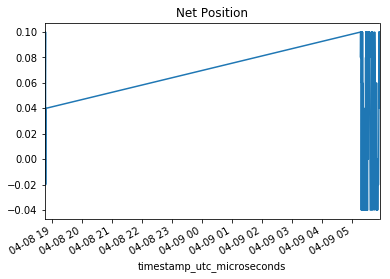

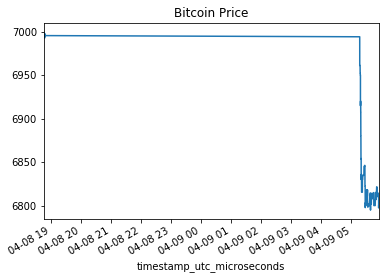

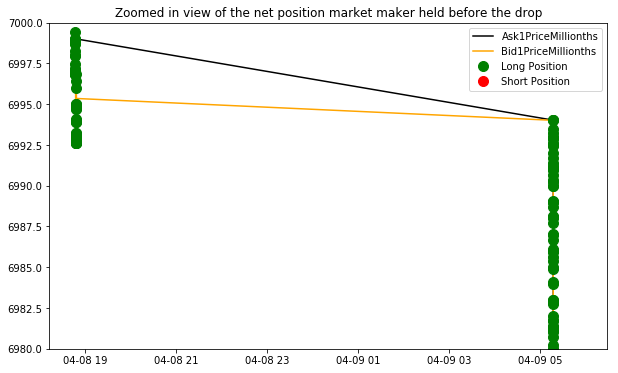

In [20]:
b = a.loc[((a['Ask1PriceMillionths'] < 7000) & (a['Ask1PriceMillionths'] > 6800))]
b['Position'].plot()
plt.title("Net Position")
plt.show()

b['Bid1PriceMillionths'].plot()
plt.title("Bitcoin Price")
plt.show()

long = b.loc[b['Position'] > 0.08]
short = b.loc[b['Position'] <= -0.04]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
plt.title("Zoomed in view of the net position market maker held before the drop")
plt.plot(b.index, b['Ask1PriceMillionths'], 'b-', color="black")
plt.plot(b.index, b['Bid1PriceMillionths'], 'b-',color="orange")
plt.plot(long.index, long['Bid1PriceMillionths'],'ro', color="green", markersize=10, label = 'Long Position')
plt.plot(short.index, short['Ask1PriceMillionths'],'ro', color="red", markersize=10, label = 'Short Position')
plt.ylim(top = 7000, bottom = 6980)

ax.legend()

plt.show()

### Conclusion:
    1) As we saw a sudden drop in the bitcoin prices in the day's data, we saw keeping a bigger long position limit caused more losses. If we reduce the maximum long position allowed in such a scenario the losses would reduce. The other way to reduce losses would have been to allow for more max short position. 
    2) The market maker was run over in the above situation as he had a long position leading up to the point of fall and even during the fall.


## Analysis on Big Trade Files 2019

In [6]:
DFTrade = pd.read_csv('mkt_make_BTC_hw_big_2019__trades.tab', sep = '\t')
DFBook = pd.read_csv('mkt_make_BTC_hw_big_2019__book_lev_2.tab', sep = '\t')

DFBook.drop(columns = ['Ask2PriceMillionths','Ask3PriceMillionths','Ask2SizeBillionths','Ask3SizeBillionths',\
                      'Bid2PriceMillionths','Bid2SizeBillionths','Bid3PriceMillionths','Bid3SizeBillionths'] \
           ,inplace = True)
DFBook['Ask1PriceMillionths'] = DFBook['Ask1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
DFBook['Bid1PriceMillionths'] = DFBook['Bid1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))

### Plot of Bitcoin Bid-Ask Price Data

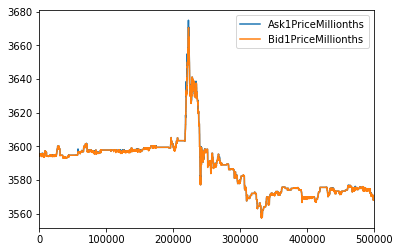

In [7]:
DFBook[['Ask1PriceMillionths','Bid1PriceMillionths']].plot()
plt.show()

In [23]:
def PnLMarketMaker(s,j,k,flag):
    
    DFTrade = pd.read_csv('mkt_make_BTC_hw_big_2019__trades.tab', sep = '\t')
    DFBook = pd.read_csv('mkt_make_BTC_hw_big_2019__book_lev_2.tab', sep = '\t')
    
    DFBook.drop(columns = ['Ask2PriceMillionths','Ask3PriceMillionths','Ask2SizeBillionths','Ask3SizeBillionths',\
                          'Bid2PriceMillionths','Bid2SizeBillionths','Bid3PriceMillionths','Bid3SizeBillionths'] \
               ,inplace = True)
    
    DFBook['Ask1PriceMillionths'] = DFBook['Ask1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
    DFBook['Ask1SizeBillionths'] = DFBook['Ask1SizeBillionths'].apply(lambda x: np.float(x)/np.float(10**9))
    DFBook['Bid1PriceMillionths'] = DFBook['Bid1PriceMillionths'].apply(lambda x: np.float(x)/np.float(10**6))
    DFBook['Bid1SizeBillionths'] = DFBook['Bid1SizeBillionths'].apply(lambda x: np.float(x)/np.float(10**9))
    
    DFTrade["PriceTimePairAsk"] = (DFTrade["timestamp_utc_microseconds"].map(int)).map(str) + DFTrade["price"].map(str)
    DFBook["PriceTimePairAsk"] = (DFBook["received_utc_microseconds"].map(int)).map(str) + \
                                                DFBook["Ask1PriceMillionths"].map(str)
    dfAsk = pd.merge(DFTrade,DFBook, on = 'PriceTimePairAsk', how = 'inner')
    dfAsk.drop(columns = ['timestamp_utc_microseconds_y','PriceTimePairAsk'], inplace = True)
    dfAsk.rename(columns = {'timestamp_utc_microseconds_x':'timestamp_utc_microseconds'}, inplace = True)
    DFTrade.drop(columns = ['PriceTimePairAsk'], inplace = True)
    
    DFTrade["PriceTimePairBid"] = (DFTrade["timestamp_utc_microseconds"].map(int)).map(str) + DFTrade["price"].map(str)
    DFBook["PriceTimePairBid"] = (DFBook["received_utc_microseconds"].map(int)).map(str) + \
                                                DFBook["Bid1PriceMillionths"].map(str)
    
    dfBid = pd.merge(DFTrade,DFBook, on = 'PriceTimePairBid', how = 'inner')
    dfBid.drop(columns = ['timestamp_utc_microseconds_y','PriceTimePairBid','PriceTimePairAsk'], inplace = True)
    dfBid.rename(columns = {'timestamp_utc_microseconds_x':'timestamp_utc_microseconds'}, inplace = True)
    DFTrade.drop(columns = ['PriceTimePairBid'], inplace = True)
    
    df = pd.concat([dfAsk,dfBid], axis = 0).reset_index(drop = True)
    df.sort_values(by = ['received_utc_microseconds'], inplace = True)
    df.drop(columns = ['Ask1SizeBillionths','Bid1SizeBillionths','received_utc_microseconds'], inplace = True)
    df.drop_duplicates(inplace = True)
    
    df['Trade'] = 0.0 * len(df.index)
    df['Cash'] = 0.0 * len(df.index)
    df['CashI/O'] = 0.0 * len(df.index)
    df['Position'] = 0.0 * len(df.index)
    
    df['timestamp_utc_microseconds'] = df['timestamp_utc_microseconds'].apply(lambda x: \
                                                                                    datetime.datetime.fromtimestamp(x/(10**6)))
    df.loc[df['price'] == df['Ask1PriceMillionths'],'Trade'] = -s
    df.loc[df['price'] == df['Bid1PriceMillionths'],'Trade'] = s
        
    #Participation criteria:
    
    for i in range(0,len(df.index)):
        if (abs(df.iat[i,2]) <= 4 * s) or ((df.iat[i-1,8] + s > j) and df.iat[i,5] == s):
            df.iat[i,5] = 0
        elif (abs(df.iat[i,2]) <= 4 * s or ((df.iat[i-1,8] -s < -k))  and df.iat[i,5] == -s):
            df.iat[i,5] = 0
            
        df.iat[i,8] = df.iat[i-1,8] + df.iat[i,5]
    
    df['CashI/O'] = - df['Trade'] * df['price']
    df['Cash'] = df['CashI/O'].cumsum()
    
    #Unwinding the trade position at the last trading point at the mid-price.
    
    last = df['price'].count()
    
    if df.iat[last-1,8] != 0:
        df.iat[last-1,5] = - df.iat[last-1,8]
        df.iat[last-1,8] = 0
        
        #Exit the position at the last data point at the mid-price
        
        df.iat[last-1,7] = - df.iat[last-1,5] * (df.iat[last-1, 3] + df.iat[last-1,4])/2
        df.iat[last-1,6] = df.iat[last-2,6] + df.iat[last-1,7]
       
    df.set_index(['timestamp_utc_microseconds'], inplace = True)
    trade_count = len(df[df['Trade'] != 0].index)
    trade_bid = len(df[df['Trade'] == s].index)             # To check the count of trades happening at the bid
    trade_ask = len(df[df['Trade'] == -s].index)            # To check the count of trades happening at the ask
    
    if flag == 1:
        return (df.iat[last-1,5],trade_count,trade_bid,trade_ask)
    else:
        return df

In [24]:
results,val = [],[]
for s in [0.01,0.02,0.03,0.05,0.07]:
    for j in [0.03,0.04,0.05,0.07,0.1]:
        for k in [0.01,0.02,0.03,0.05,0.07,0.1]:
            a = PnLMarketMaker(s,j,k,1)
            results.append(a[0])
            val.append([s,j,k,a[1],a[2],a[3]])

In [25]:
a = pd.DataFrame(val)
b = pd.DataFrame(results)
a = a.rename(columns={0: "s", 1: "j", 2: "k", 3: "Trade Count", 4: "Bid Trades", 5: "Ask Trades"})
b = b.rename(columns = {0: "PnL"})
c = pd.concat([a,b],axis = 1)
c = c.drop(c[c.s >= c.j].index)
c = c.drop(c[c.s >= c.k].index)
c = c.drop(c[c.k >= c.j].index)
c = c.sort_values(by=['PnL'], ascending = True)
c.head()

,s,j,k,Trade Count,Bid Trades,Ask Trades,PnL
118,0.05,0.1,0.07,859,430,428,-18.5325
88,0.03,0.1,0.07,1409,705,703,-13.8663
87,0.03,0.1,0.05,1339,670,668,-12.7377
57,0.02,0.1,0.05,1914,958,955,-10.8635
56,0.02,0.1,0.03,1856,929,926,-10.6777


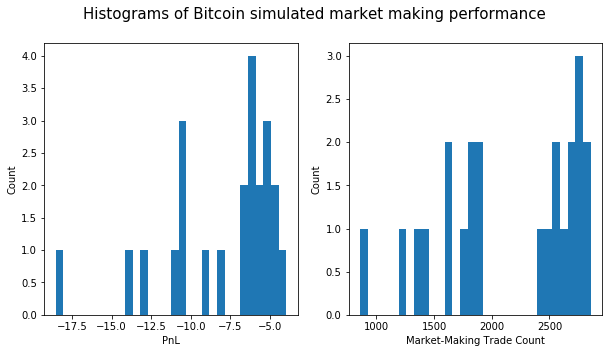

In [26]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize=(10, 5))
fig.suptitle('Histograms of Bitcoin simulated market making performance',fontsize = 15)

plt.subplot(1,2,1)
plt.hist(c['PnL'], bins = 30)
plt.xlabel("PnL")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(c['Trade Count'], bins = 30)
plt.xlabel("Market-Making Trade Count")
plt.ylabel("Count")

plt.show()

### Conclusion
    1) From the above histogram for PnL we can observe that market making in Bitcoin is not a profitable business. In all (fro the set of parameter taken) the simulations we lose money. The reason being the spreads are very low and there is a high risk of being run over causing losses.
    2) The set of parameters used to generate above simulations generate lesser trading oportunities when compared to the 2018 data,as seen from the above Market making trade count - a measure of participation by the market maker.

### Scatter Plots of the results

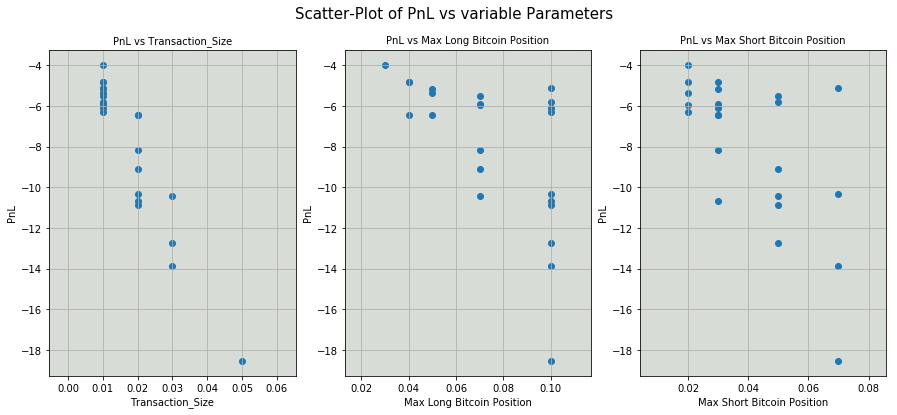

In [27]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize=(15, 6))
fig.suptitle('Scatter-Plot of PnL vs variable Parameters',fontsize = 15)

plt.subplot(1,3,1)
plt.scatter(c['s'],c['PnL'])
plt.title("PnL vs Transaction_Size",fontsize = 10)
plt.xlabel("Transaction_Size")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.subplot(1,3,2)
plt.scatter(c['j'],c['PnL'])
plt.title("PnL vs Max Long Bitcoin Position",fontsize = 10)
plt.xlabel("Max Long Bitcoin Position")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')


plt.subplot(1,3,3)
plt.scatter(c['k'],c['PnL'])
plt.title("PnL vs Max Short Bitcoin Position",fontsize = 10)
plt.xlabel("Max Short Bitcoin Position")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.show()

### Conclusion:
    1) From the above scatter plot we can comment that the transaction size is inversely related to the PnL(same as 2018 result).
    2) Also if we allow for higher maximum long position bitcoin position , this increases the run over risk and hence we observe an inverse relationship in PnL and Max Long Bitcoin Position parameter.
    3) We see a similar relationship between the PnL and short bitcoin position because as this parameter goes up , the market maker gets into more adverse trades which causes some cases of extreme loses.

### Boxplots

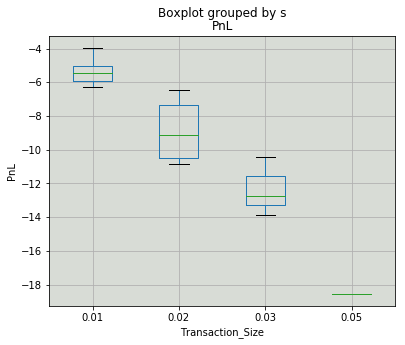

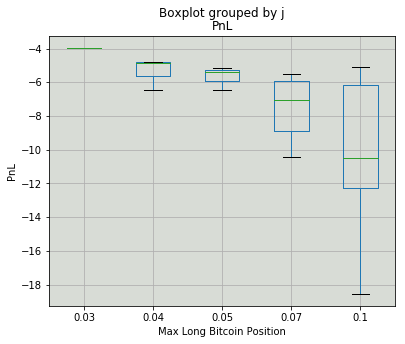

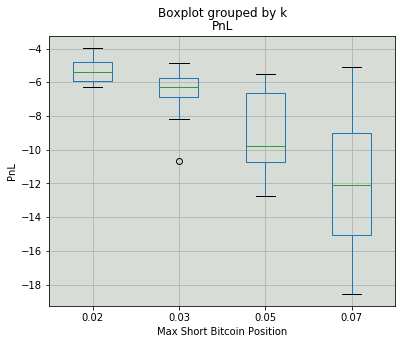

In [28]:
boxplot = c.boxplot(column=['PnL'], by='s', figsize = (6,5), fontsize = 10)
plt.xlabel("Transaction_Size")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
plt.show()

boxplot = c.boxplot(column=['PnL'], by='j', figsize = (6,5), fontsize = 10)
plt.xlabel("Max Long Bitcoin Position")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

boxplot = c.boxplot(column=['PnL'], by='k',figsize = (6,5), fontsize = 10)
plt.xlabel("Max Short Bitcoin Position")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

### Plot of the trading activities for a particular set of parameters

    1) I have shown the PnL accumulation of the trading strategy( Equity Curve ).

In [29]:
a = PnLMarketMaker(0.03,0.1,0.05,0)

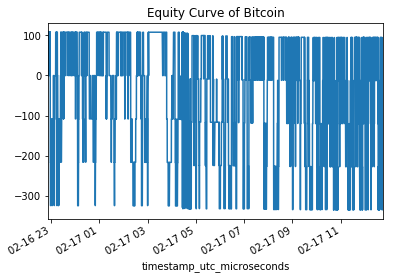

In [32]:
a['Cash'].plot()
plt.title("Equity Curve of Bitcoin")
plt.show()